## 1. Module Import and Hyper-parameters Setting

### 1-1. Setup & Module Import

In [2]:
!pip install pennylane qiskit[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 957 kB 7.8 MB/s 
     |████████████████████████████████| 9.3 MB 20.8 MB/s 
     |████████████████████████████████| 1.6 MB 38.6 MB/s 
     |████████████████████████████████| 108 kB 45.8 MB/s 
     |████████████████████████████████| 6.5 MB 16.5 MB/s 
     |████████████████████████████████| 18.0 MB 265 kB/s 
     |████████████████████████████████| 240 kB 63.2 MB/s 
     |████████████████████████████████| 198 kB 46.3 MB/s 
     |████████████████████████████████| 162 kB 76.9 MB/s 
     |████████████████████████████████| 112 kB 60.1 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 49 kB 8.1 MB/s 
     |████████████████████████████████| 49 kB 8.0 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 943 kB 58.6 MB/s 
     |████████████████████████████████

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# import os
import pennylane as qml
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer
from qiskit.extensions import Initialize
#from pennylane.templates import RandomLayers
#from pennylane_ionq import ops

'''
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
'''

'\nimport qiskit\nfrom qiskit import transpile, assemble\nfrom qiskit.visualization import *\nfrom qiskit.circuit.random import random_circuit\n\nimport torch\nfrom torch.autograd import Function\nfrom torchvision import datasets, transforms\nimport torch.optim as optim\nimport torch.nn as nn\nimport torch.nn.functional as F\n'

### 1-2. Setting of the main hyper-parameters of the model

In [4]:
BATCH_SIZE = 16
n_qubits = 9
n_params = 90
n_epochs = 100  # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 1280  # Size of the train dataset
n_test = 320    # Size of the test dataset

SAVE_PATH = "aeqis/" # Data saving folder
seed = 2022
np.random.seed(seed)        # Seed for NumPy random number generator

isReal = False # 'True' for real device or 'False' for simulator

In [5]:
if isReal:
  dev = qml.device("qiskit.ibmq", wires=9)
else:
  dev = qml.device("default.mixed", wires=9)

## 2. Construct Quantum Circuit

### 2-1. One Qubit Unitary Circuit 

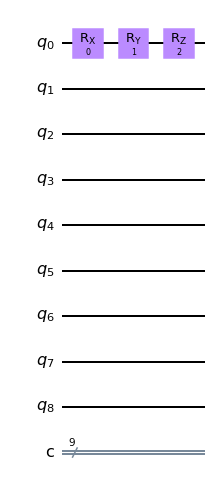

In [6]:
def one_qubit_unitary(params, wire):  # need 3 parameters
  circ = QuantumCircuit(n_qubits, n_qubits, name = '1 Qubit Unitary')

  circ.rx(params[0],wire)
  circ.ry(params[1],wire)
  circ.rz(params[2],wire)
  
  return circ

params = np.arange(0, 3)
one_qubit_unitary(params, 0).draw(output='mpl')

### 2-2. Two Qubits Unitary Circuit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  
/usr/local/

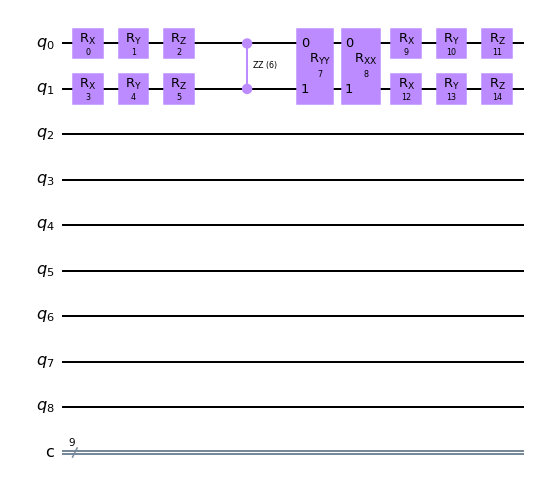

In [19]:
def two_qubit_unitary(params, wires):  # need 15 parameters
  circ = QuantumCircuit(n_qubits, n_qubits, name = '2 Qubit Unitary')
  circ += one_qubit_unitary(params[0:3], wires[0])
  circ += one_qubit_unitary(params[3:6], wires[1])
  circ.rzz(params[6], wires[0], wires[1])
  circ.ryy(params[7], wires[0], wires[1])
  circ.rxx(params[8], wires[0], wires[1])
  circ += one_qubit_unitary(params[9:12], wires[0])
  circ += one_qubit_unitary(params[12:15], wires[1])
  #circ.barrier()

  return circ

params = np.arange(0, 15)
two_qubit_unitary(params, [0,1]).draw(output='mpl')

### 2-3. Three Qubits Unitary Circuit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  
/usr/local/

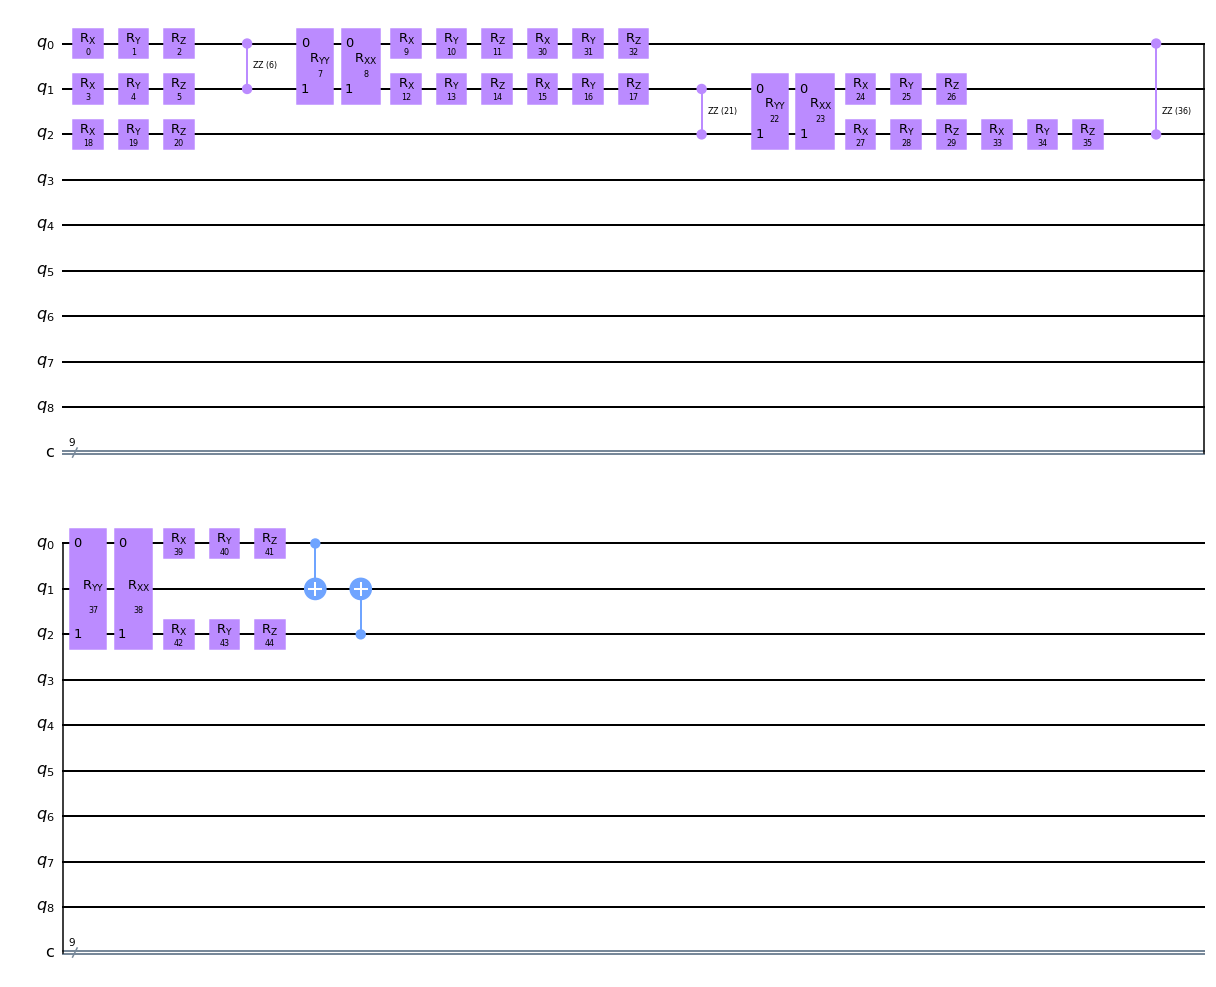

In [27]:
def three_qubit_unitary(params, wires):  # need 45 parameters
  circ = QuantumCircuit(n_qubits, n_qubits, name = '3 Qubit Unitary')
  circ += two_qubit_unitary(params[0:15], [wires[0],wires[1]])
  circ += two_qubit_unitary(params[15:30], [wires[1],wires[2]])
  circ += two_qubit_unitary(params[30:45], [wires[0],wires[2]])

  circ.cx(wires[0], wires[1])
  circ.cx(wires[2], wires[1])
  #circ.barrier()

  #circ.measure([wires[0],wires[2]], [0, 0])   
  #circ.barrier()

  return circ

params = np.arange(0, 45)
three_qubit_unitary(params, [0,1,2]).draw(output='mpl')

### 2-4. Decoder Circuit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  
/usr/local/

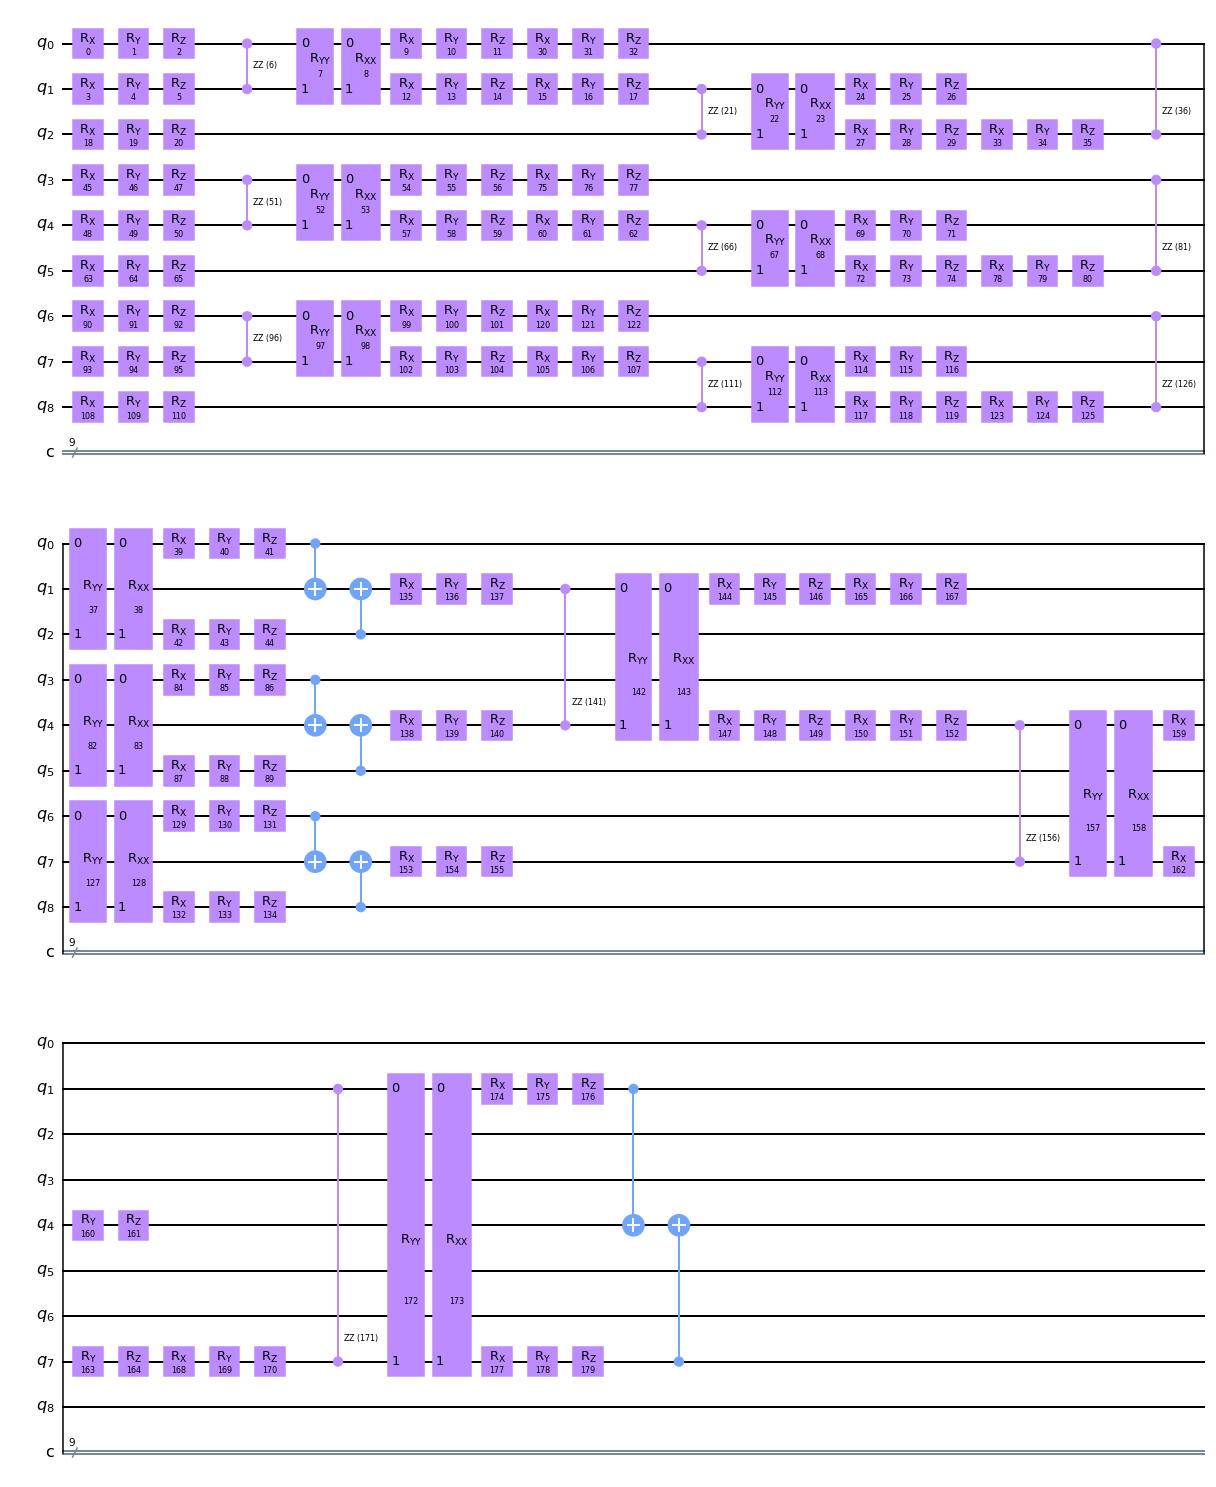

In [28]:
# Defining Decoder circuit.
def decoder(params):  # need 90 parameters
  dec = QuantumCircuit(n_qubits, n_qubits, name = '3 Qubit Unitary')
  dec += three_qubit_unitary(params[0:45], np.arange(0,3))
  dec += three_qubit_unitary(params[0:45], np.arange(3,6))
  dec += three_qubit_unitary(params[90:135], np.arange(6,9))

  dec += three_qubit_unitary(params[135:180], [1,4,7])

  return dec

params = np.arange(0, 180)
decoder(params).draw(output='mpl')

### 2-5. Encoder Circuit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  
/usr/local/

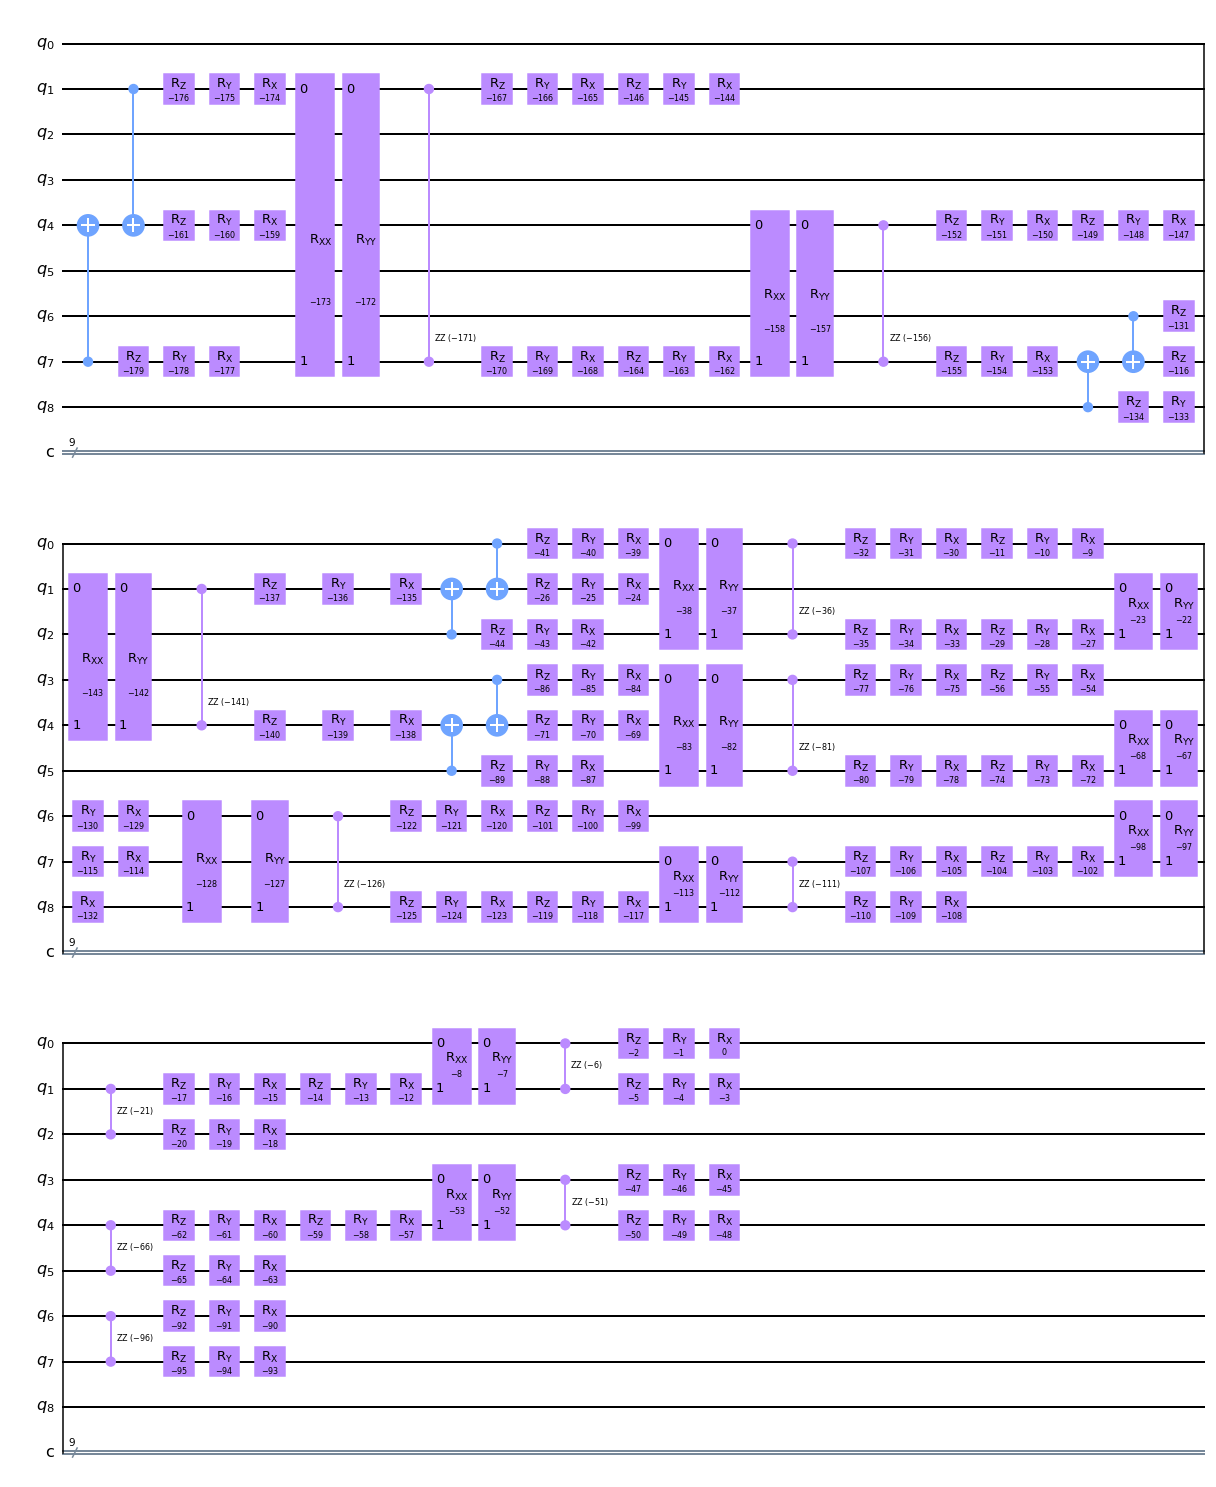

In [31]:
# Defining Encoder circuit. Encoder is inversion of Decoder.
def encoder(decoder):
    enc = QuantumCircuit(n_qubits, n_qubits, name = 'Encoder')
    enc = decoder.inverse()
    
    return enc

# visualizing Encoder to check
params = np.arange(0, 180)
encoder(decoder(params)).draw(output='mpl')

### 2-6. Complete Circuit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  
/usr/local/

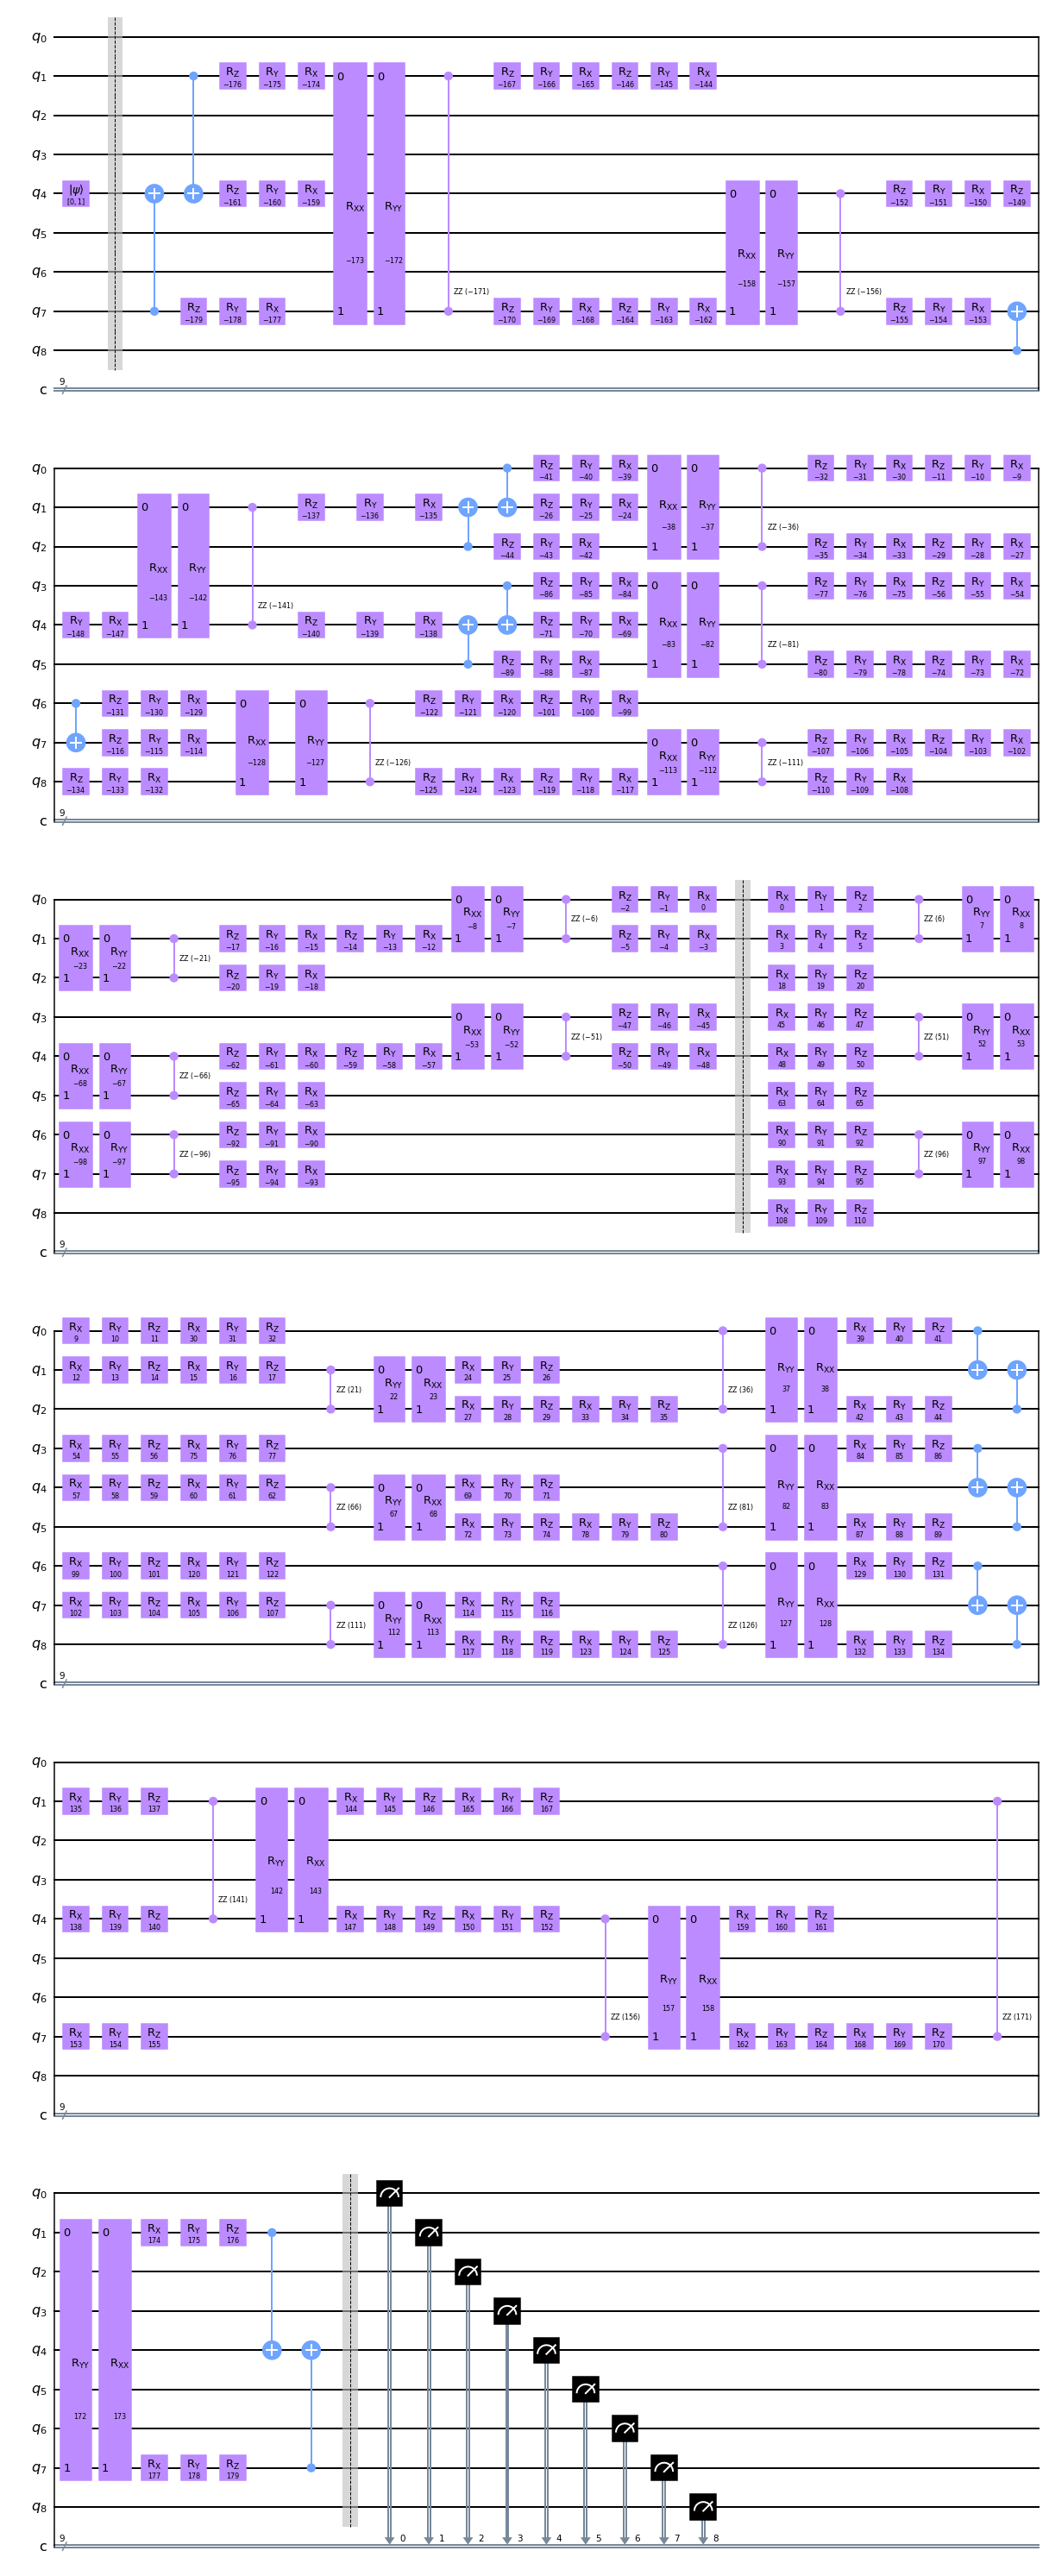

In [38]:
def qae(params, input_state, error_qubit):  # need 180 parameters
  qc = QuantumCircuit(n_qubits, n_qubits, name = 'Quantum Autoencoder')
  qc.append(input_state, [4])
  qc.barrier()

  dec = decoder(params)
  qc += encoder(dec)
  # qc += noisemodel
  qc.barrier()
  qc += dec

  qc.barrier()
  qc.measure(np.arange(0,9), np.arange(0,9)) 

  return qc

params = np.arange(0, 180)
initial_state = [0, 1]
input_state = Initialize(initial_state)
qae(params, input_state, 1).draw(output='mpl')

In [ ]:
print(pqc(torch.tensor([1,0,2,1,2,3,1,2,0]),torch.tensor([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]), 'random'))

tensor(0.5221, dtype=torch.float64)


### 2-2. Create a 'QuanvNet Class' with PyTorch

In [ ]:
class QuanvNet(torch.nn.Module):
    def __init__(self,qc=True,opt=True,circuit_type=9):
        super().__init__()
        self.qc = qc
        self.opt = opt
        self.n_qubits = 9
        self.filters = 1
        self.conv_opt = torch.nn.Conv2d(in_channels=self.filters,out_channels=self.filters,kernel_size=3)
        self.conv1 = torch.nn.Conv2d(in_channels=self.filters,out_channels=8,kernel_size=3,padding='same')
        self.pre_pool = torch.nn.AvgPool2d(2)
        self.pool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(in_channels=8,out_channels=8,kernel_size=3)
        self.fc1 = torch.nn.Linear(200,16)
        self.fc2 = torch.nn.Linear(16,10)
        self.dropout = torch.nn.Dropout(0.4)
        if circuit_type == 2:
          self.num_q_params = 2*self.n_qubits
        elif circuit_type == 3:
          self.num_q_params = 3*self.n_qubits - 1
        elif circuit_type == 9:
          self.num_q_params = self.n_qubits
        elif circuit_type == 10:
          self.num_q_params = 2*self.n_qubits
        self.q_params = torch.nn.Parameter(2*np.pi*torch.rand(self.filters,self.num_q_params))
        self.q_params.requires_grad = True
        if self.qc:
          self.circuit_type = circuit_type
        else:
          self.circuit_type = 0

    def forward(self, inputs, check_plot=0):
        if self.qc == True:
            out = torch.zeros((BATCH_SIZE,self.filters,12,12))
            for bat, image in enumerate(inputs):
                for j in range(1, 13, 1):
                    for k in range(1, 13, 1):
                        for i in range(self.filters):
                            window = image[0, j-1:j+2, k-1:k+2].squeeze()
                            window_flatten = window.reshape(self.n_qubits)
                            q_results = pqc(
                                window_flatten,
                                self.q_params[i],
                                circuit_type=self.circuit_type
                            )
                            if use_cuda:
                              out[bat,i,j - 1, k - 1] = F.relu(q_results.cuda())
                            else:
                              out[bat,i,j - 1, k - 1] = F.relu(q_results)

            if check_plot == 1:
              pltsize = 1
              plt.figure(figsize=(BATCH_SIZE * pltsize, n_channels * pltsize))
              for i in range(BATCH_SIZE):
                for j in range(0, n_channels, 3):
                  plt.subplot((n_channels+2)/3, BATCH_SIZE, i + j*BATCH_SIZE/3 + 1)
                  plt.axis('off')
                  plt.imshow(out[i, j, :, :].reshape(12, 12), cmap = "gray_r")

        else:
          if use_cuda:
            out = torch.zeros((BATCH_SIZE,self.filters,14,14)).cuda()
          else:
            out = torch.zeros((BATCH_SIZE,self.filters,14,14))
          out = inputs
        # print(out.size())
        if self.opt==True:
          out = F.relu(self.conv_opt(inputs))
        # print("out", out.type)
        x = self.pool(F.relu(self.conv1(out)))

        # print("x", x.type)
        # print(x.size())
        # print(x.size())
        if check_plot == 1:
          conv_image = x.cpu().detach().numpy()
          pltsize = 1
          plt.figure(figsize=(BATCH_SIZE * pltsize, n_channels * pltsize))
          for i in range(BATCH_SIZE):
            for j in range(0, n_channels, 3):
              plt.subplot((n_channels+2)/3, BATCH_SIZE, i + j*BATCH_SIZE/3 + 1)
              plt.axis('off')
              plt.imshow(conv_image[i, j, :, :].reshape(6, 6), cmap = "gray_r")
        
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x))
        if use_cuda:
          return x.cuda()
        else:
          return x

NameError: ignored

In [ ]:
from torchsummary import summary
criterion = torch.nn.CrossEntropyLoss()
model = QuanvNet(qc=True,opt=False)
if use_cuda:
    model.cuda()
opt = optim.Adam(model.parameters(),lr=0.01)
summary(model,(1,14,14))

In [ ]:
for p in model.parameters():
    print(p.shape)

In [ ]:
losses = []
accs = []
for epoch in range(10000):
  train_loss = 0
  acc = 0
  for (x_train, y_train) in train_loader:
    # print(y_train)
    opt.zero_grad()
    outputs = model(x_train.cuda() if use_cuda else x_train)
    _, preds = torch.max(outputs,1)
    acc += (preds==(y_train.cuda() if use_cuda else y_train)).sum().item()
    loss = criterion(outputs,(y_train.cuda() if use_cuda else y_train))
    loss.backward()
    opt.step()
    train_loss += loss
    del loss
  acc /= n_train
  train_loss /= (n_train/BATCH_SIZE)
  if epoch%10 == 9:
    if epoch%100 == 99:
      print(epoch+1,train_loss)
    losses.append(train_loss.item())
  if epoch%10 == 9:
    accs.append(acc) 
  del acc

In [ ]:
from matplotlib.pyplot import plot
x = np.arange(0,10000,10)
plot(x,losses)

In [ ]:
x = np.arange(0,10000,10)
plot(x,accs)

In [ ]:
file = pd.DataFrame(data={'train_loss': losses,
                          'train_acc': accs})
file.to_pickle(file_name)